In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd
import json
import os
import json
import re
import traceback
from os.path import exists
import requests
from tqdm import tqdm

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import os

game_type_map = {"regular_season": "02",
                 "playoffs": "03"}


class Directory:
    DATA_DIR = "/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/data/" # Modify the path accordingly
    FIG_DIR = "/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/figures/" # Modify the path accordingly
    
class APIList():
    GET_ALL_MATCHES_FOR_A_GIVEN_SEASON = "https://statsapi.web.nhl.com/api/v1/schedule?season="
    GET_ALL_DATA_FOR_A_GIVEN_MATCH = "https://statsapi.web.nhl.com/api/v1/game/{}/feed/live/"


class CustomRegex():
    REGULAR_GAME_ID = r"\d{0,4}02\d{0,4}"  # 02 for regular season
    PLAYOFFS_ID = r"\d{0,4}03\d{0,4}"  # 03 for playoffs

TYPES_OF_SHOTS = ["Goal", "Shot"]

In [4]:
def get_json_path(game_id=0, season=0):
    """
    This function takes an input game id and return the location of the json file
    @param game_id: game id for which we need to get the data
    @return: local system path
    """
    if game_id != 0:
        year = str(game_id)[:4]
        season = str(game_id)[4:6]
        if season == "02":
            game_type = "regular_season"
        elif season == "03":
            game_type = "playoffs"
        else:
            game_type = ""
        return Directory.DATA_DIR + year + os.path.sep + str(year) + "_" + game_type + ".json", ""
    elif season != 0:
        regular_season = Directory.DATA_DIR + str(season) + os.path.sep + str(season) + "_regular_season.json"
        playoffs_season = Directory.DATA_DIR + str(season) + os.path.sep + str(season) + "_playoffs.json"
        return regular_season, playoffs_season


def flatten_player_data(player_list):
    """
    This function transform list of players into a flatten encoded string in the form of (Full Name)_(Player Type)|
    (Full Name)_(Player Type)|.....
    @param player_list: list of players data
    @return: flatten string
    """
    flatten_string = ""
    for player in player_list:
        # flatten_string += "(" + player["player"]["id"] + ")_" # Can be uncommented in future if required
        flatten_string += "(" + player["player"]["fullName"] + ")_"
        flatten_string += "(" + player["playerType"] + ")|"
    return flatten_string[:-1]


def get_shooter_goalie(player_list):
    shooter = ""
    goalie = ""
    for player in player_list:
        if player["playerType"] == "Shooter":
            shooter = player["player"]["fullName"]
        elif player["playerType"] == "Goalie":
            goalie = player["player"]["fullName"]
        else:
            pass
    return shooter, goalie


def get_home_away_team(game_meta):
    teams_data = game_meta["gameData"]["teams"]
    return {"home": teams_data["home"]["name"], "away": teams_data["away"]["name"]}


def get_side(game_meta):
    periods_data = game_meta["liveData"]["linescore"]["periods"]
    period_dict = {}
    if len(periods_data) > 0:
        for i, period in enumerate(periods_data):
            if "rinkSide" in period["home"]:
                period_dict[i + 1] = {"home": period["home"]["rinkSide"], "away": period["away"]["rinkSide"]}
            else:
                period_dict[i + 1] = {"home": "Side Not Available", "away": "Side Not Available"}
    return period_dict


def data_parsing(data, id, event_type, period_dict, team_detail_dict):
    """
    This functions transforms the json data into the relevant information for the usecase
    @param data: entire metadata and details of the given game id
    @param id: game id
    @param event_type: type of game Shot / Goal
    @return: json object
    """
    players_data = data["players"]
    result_data = data["result"]
    about_data = data["about"]
    coordinates_data = data["coordinates"]
    team_data = data["team"]
    shooter, goalie = get_shooter_goalie(players_data)
    data_dict = {"game_id": id, "event_code": result_data["eventCode"],
                 "player_info": flatten_player_data(players_data),
                 "shooter": shooter, "goalie": goalie, "event": result_data["event"],
                 "event_type_id": result_data["eventTypeId"], "event_description": result_data["description"],

                 "home_team": team_detail_dict["home"], "away_team": team_detail_dict["away"],

                 "about_event_id": about_data["eventId"], "about_period": about_data["period"],
                 "about_period_type": about_data["periodType"], "game_time": about_data["periodTime"],
                 "about_time_remaining": about_data["periodTimeRemaining"], "about_date_time": about_data["dateTime"],
                 "about_goal_away": about_data["goals"]["away"], "about_goal_home": about_data["goals"]["home"],
                 "action_team_name": team_data["name"]}

    if "secondaryType" not in result_data:
        data_dict["event_secondary_type"] = "NA"
    else:
        data_dict["event_secondary_type"] = result_data["secondaryType"]

    x = "NA"
    y = "NA"
    if "x" in coordinates_data:
        x = coordinates_data["x"]
    if "y" in coordinates_data:
        y = coordinates_data["y"]
    data_dict["coordinates"] = (x, y)

    if about_data["period"] not in period_dict:
        data_dict["home_team_side"] = "NA-Shootout"
        data_dict["away_team_side"] = "NA-Shootout"
    else:
        data_dict["home_team_side"] = period_dict[about_data["period"]]["home"]
        data_dict["away_team_side"] = period_dict[about_data["period"]]["away"]

    if event_type == "Goal":
        data_dict["event_strength_name"] = result_data["strength"]["name"]
        data_dict["event_strength_code"] = result_data["strength"]["code"]
        data_dict["event_game_winning_goal"] = result_data["gameWinningGoal"]
        if "emptyNet" not in result_data:
            data_dict["event_empty_net"] = "Missing Data"
        else:
            data_dict["event_empty_net"] = result_data["emptyNet"]
    else:
        data_dict["event_strength_name"] = "NA"
        data_dict["event_strength_code"] = "NA"
        data_dict["event_game_winning_goal"] = "NA"
        data_dict["event_empty_net"] = "NA"
    return data_dict


def get_goal_shots_data_by_game_id(game_id: int):
    """
    This functions transforms the json data into a df by filtering the relevant live data of the matchs which is
    restricted to "Shots" and "Goals"
    @param game_id: game id for which the transformed data needs to be done
    @return: data frame which consists of shots and goals data
    """
    json_path, _ = get_json_path(game_id=game_id)
    with open(json_path, "r") as f:
        playoffs_game_data_dict = json.load(f)
    game_data = playoffs_game_data_dict[str(game_id)]

    period_dict = get_side(game_meta=game_data)
    teams_type = get_home_away_team(game_meta=game_data)
    live_data = game_data["liveData"]["plays"]["allPlays"]
    final_list = []
    for i in live_data:
        if i["result"]["event"] in TYPES_OF_SHOTS:
            try:
                parsed_data = data_parsing(data=i, id=game_id, event_type=i["result"]["event"],
                                           period_dict=period_dict, team_detail_dict=teams_type)
                final_list.append(parsed_data)
            except Exception as e:
                print(e)
                import traceback
                print(traceback.print_exc())
                break

    shots_goals_df = pd.DataFrame(final_list)
    return shots_goals_df


def get_goal_shots_by_season(season_year: int):
    regular_data_path, playoffs_data_paths = get_json_path(season=season_year)
    with open(regular_data_path, "r") as f:
        regular_game_data_dict = json.load(f)

    with open(playoffs_data_paths, "r") as p:
        playoffs_game_data_dict = json.load(p)

    total_game_list = []
    for key, val in tqdm(regular_game_data_dict.items()):
        game_data = regular_game_data_dict[str(key)]
        period_dict = get_side(game_meta=game_data)
        teams_type = get_home_away_team(game_meta=game_data)
        live_data = game_data["liveData"]["plays"]["allPlays"]
        for i in live_data:
            if i["result"]["event"] in TYPES_OF_SHOTS:
                try:
                    parsed_data = data_parsing(data=i, id=key, event_type=i["result"]["event"],
                                               period_dict=period_dict, team_detail_dict=teams_type)
                    total_game_list.append(parsed_data)
                except Exception as e:
                    print(key)
                    print(e)
                    import traceback
                    print(traceback.print_exc())
                    break

    for key, val in tqdm(playoffs_game_data_dict.items()):
        game_data = playoffs_game_data_dict[str(key)]
        period_dict = get_side(game_meta=game_data)
        teams_type = get_home_away_team(game_meta=game_data)
        live_data = game_data["liveData"]["plays"]["allPlays"]
        for i in live_data:
            if i["result"]["event"] in TYPES_OF_SHOTS:
                try:
                    parsed_data = data_parsing(data=i, id=key, event_type=i["result"]["event"],
                                               period_dict=period_dict, team_detail_dict=teams_type)
                    total_game_list.append(parsed_data)
                except Exception as e:
                    print(i)
                    print(key)
                    print(e)
                    import traceback
                    print(traceback.print_exc())
                    break

    shots_goals_df = pd.DataFrame(total_game_list)
    return shots_goals_df

In [5]:
# Format data frame with all years that we need
df = []
year = [2015, 2016, 2017, 2018] # add 2015
for y in year:
    print(y)
    data = get_goal_shots_by_season(season_year=y)
    data['season'] = y
    df.append(data)
df = pd.concat(df)

2015


100%|██████████| 91/91 [00:00<00:00, 1336.03it/s]


2016


100%|██████████| 87/87 [00:00<00:00, 1587.74it/s]


2017


100%|██████████| 84/84 [00:00<00:00, 1645.25it/s]


2018


100%|██████████| 87/87 [00:00<00:00, 1572.93it/s]


In [6]:
# Add distinct columns for x and y coordinates
df['x_coordinate'] = df['coordinates'].apply(lambda x: x[0])
df['y_coordinate'] = df['coordinates'].apply(lambda x: x[1])

In [7]:
# Replace NAs by np.nan and type as float
df['x_coordinate'].replace({'NA': np.nan}, inplace = True)
df['x_coordinate'] = df['x_coordinate'].astype('float')
df['y_coordinate'].replace({'NA': np.nan}, inplace = True)
df['y_coordinate'] = df['y_coordinate'].astype('float')

In [8]:
def distance(x_coordinate: float, y_coordinate: float, shoot_side: str) -> float:
    """
    This functions computes the distance at which a shot was taken, i.e. the distance between the coordinates and the goal, 
    taking the goal side into account
    @param x_coordinate: x coordinates on the ice
    @param y_coordinate: y coordinates on the ice
    @param shoot_side: side of the goal at which the shot is aimed at
    @return: distance
    """
    x = np.nan
    y = np.nan
    if shoot_side == 'right':
        x = 89 - x_coordinate
        y = y_coordinate
    elif shoot_side == 'left':
        x = -89 - x_coordinate
        y = y_coordinate
    else: 
        pass
    distance = math.hypot(x,y)
    return distance

In [9]:
def angle(x_coordinate: float, y_coordinate: float, shoot_side: str) -> float:
    """
    This functions computes the angle at which a shot was taken, i.e. the distance is 0 if the shot is taken from 
    in front of the goal, positive if from the right side, and negative if from the left side
    @param x_coordinate: x coordinates on the ice
    @param y_coordinate: y coordinates on the ice
    @param shoot_side: side of the goal at which the shot is aimed at
    @return: angle
    """
    x = np.nan
    y = np.nan
    if shoot_side == 'right':
        x = 89 - x_coordinate
        y = y_coordinate
    elif shoot_side == 'left':
        x = -(-89 - x_coordinate)
        y = y_coordinate
    else: 
        pass
    angle = math.atan2(y,x)*180/math.pi
    return angle

In [10]:
# Add the side of the goal at which the shot is aimed - this is the opposite side of that of the team which is shooting
df.loc[(df['action_team_name'] == df['away_team']), 'shoot_side'] = df.loc[(df['action_team_name'] == df['away_team']), 'home_team_side']
df.loc[(df['action_team_name'] == df['home_team']), 'shoot_side'] = df.loc[(df['action_team_name'] == df['home_team']), 'away_team_side']

# Compute the distance from the goal
df['distance'] = np.vectorize(distance)(df['x_coordinate'], df['y_coordinate'], df['shoot_side'])

/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in distance (vectorized)
  outputs = ufunc(*inputs)


In [11]:
# Compute the angle 
df['angle'] = np.vectorize(angle)(df['x_coordinate'], df['y_coordinate'], df['shoot_side'])

In [12]:
# Create Goal variable
df['is_goal'] = np.where(df['event']=='Goal',1,0)

In [13]:
# Create Empty Net variable
df['empty_net'] = np.where(df['event_empty_net']==True,1,0)

In [14]:
df.shape

(332742, 35)

In [15]:
# Save Tidy Data
df.to_csv(Directory.DATA_DIR + 'train_set.csv')

In [16]:
df = pd.read_csv(Directory.DATA_DIR + 'train_set.csv')

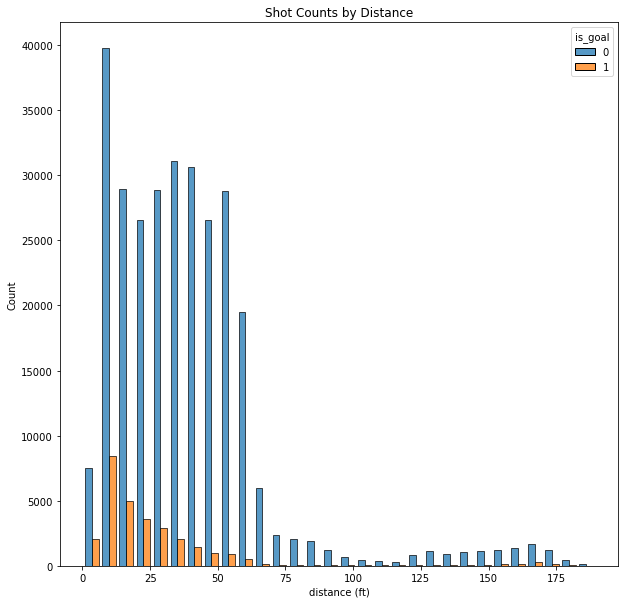

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=df, x='distance', bins=30, hue='is_goal', multiple="dodge", shrink=0.8)
ax.set(xlabel='distance (ft)')
ax.set(title='Shot Counts by Distance')
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_1_Shot_Counts_by_Distance.png"
fig.savefig(path)

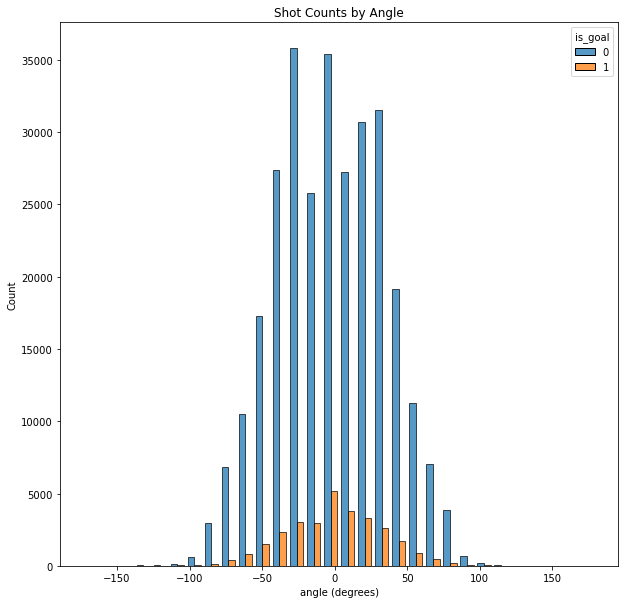

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.histplot(data=df, x='angle', bins=30, hue='is_goal', multiple="dodge", shrink=0.8)
ax.set(xlabel='angle (degrees)')
ax.set(title='Shot Counts by Angle')
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_2_Shot_Counts_by_Angle.png"
fig.savefig(path)

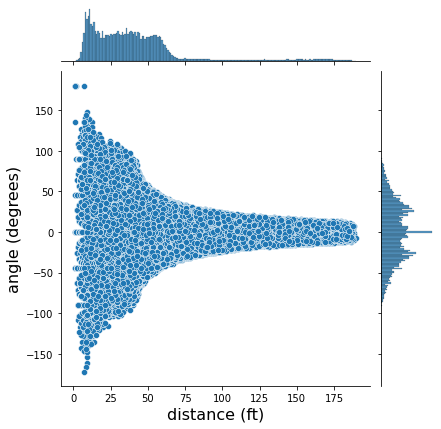

In [19]:
ax = sns.jointplot(data=df, x='distance', y='angle')
ax.set_axis_labels('distance (ft)', 'angle (degrees)', fontsize=16)
plt.show()
# Save figure
fig = ax.fig
path = Directory.FIG_DIR + "figure_3_jointplot_Distance_Angle.png"
fig.savefig(path)

In [20]:
df['distance_category'] = pd.cut(df['distance'], 30, ordered=True, precision=0)
goal_rate = df.groupby(by='distance_category').sum()/df.groupby(by='distance_category').count()
goal_rate['distance_category'] = goal_rate.index

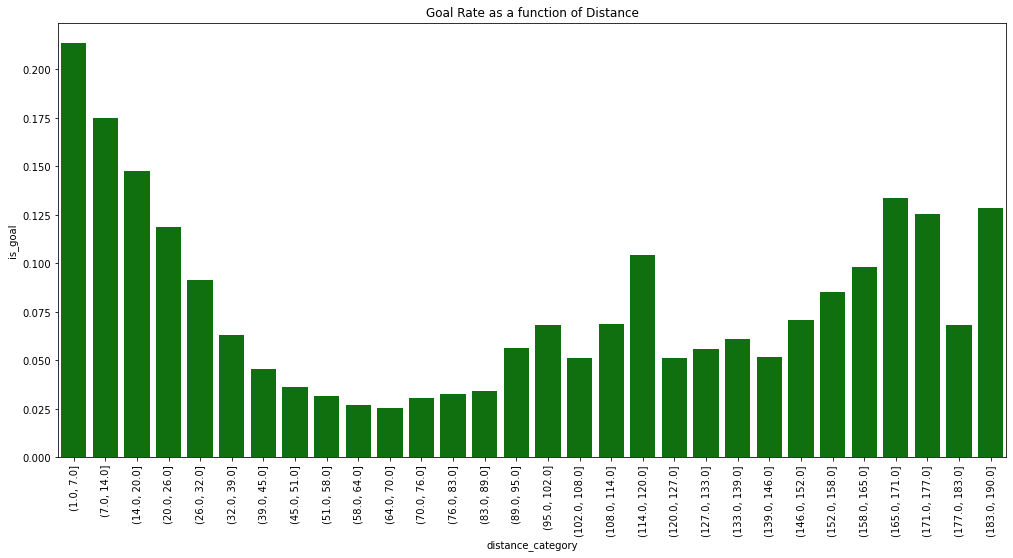

In [21]:
fig, ax = plt.subplots(figsize=(17, 8))
ax = sns.barplot(data=goal_rate, x='distance_category', y='is_goal', color='green')
ax.set(title='Goal Rate as a function of Distance')
plt.xticks(rotation=90)
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_4_Goal_Rate_as_a_function_of_Distance.png"
fig.savefig(path)

# Discuss observations:

First, there is a relationship between the distance and the probability of a goal, such as the probability of a goal is inversely proportionnal to distance when distance is less than approximately 60 ft. 

Second, there is some (stochastic) probability of a goal with shots taken at approximately more than 60 feet which can be in some cases higher than for goals taken at about 60 feet. 

In [22]:
df['angle_category'] = pd.cut(df['angle'], 30, ordered=True, precision=0)
goal_rate = df.groupby(by='angle_category').sum()/df.groupby(by='angle_category').count()
goal_rate['angle_category'] = goal_rate.index

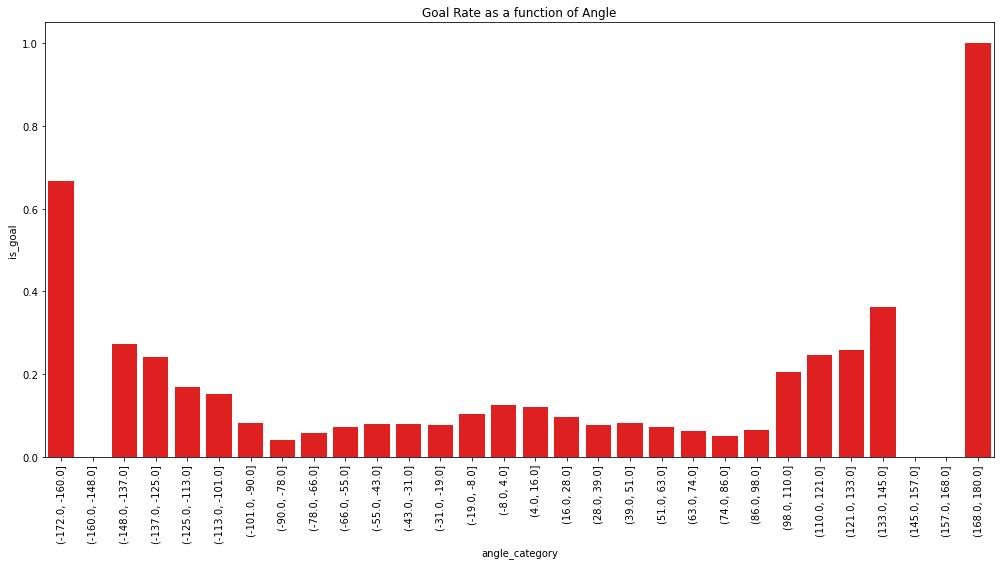

In [23]:
fig, ax = plt.subplots(figsize=(17, 8))
ax = sns.barplot(data=goal_rate, x='angle_category', y='is_goal', color='red')
ax.set(title='Goal Rate as a function of Angle')
plt.xticks(rotation=90)
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_5_Goal_Rate_as_a_function_of_Angle.png"
fig.savefig(path)

# Discuss observations
First, there is slighly more chance that a goal results in a goal when it is taken from in front of the goal, but only when the shot is taken at less than 90 degrees. 

Second, even though shots taken from in front of the goal (i.e. at an angle close to zero) are the most common, these are not the most successful in achieving a goal. In fact, the likelihood of a goal increases as a proportion to the angle, specifically when the angle is greater than approximately 90 degrees. 

Third and very important, the distribution is symmetric only in its middle part. There is a very clear asymetry when comparing the extremities of the distribution. Specifically, shots taken at very high angles (approximately more than 150 degrees) are more likely to achieve a goal when taken from the side which corresponds to the right-hand side of the goaley. We need to bear in mind that most goaleys are right-handed and hold their hockey sticks on the left side as all other players, and therefore their right side is relatively unprotected. This might explain why shots taken from the far-right-hand side of the goaley are much more likely to result in a goal. 

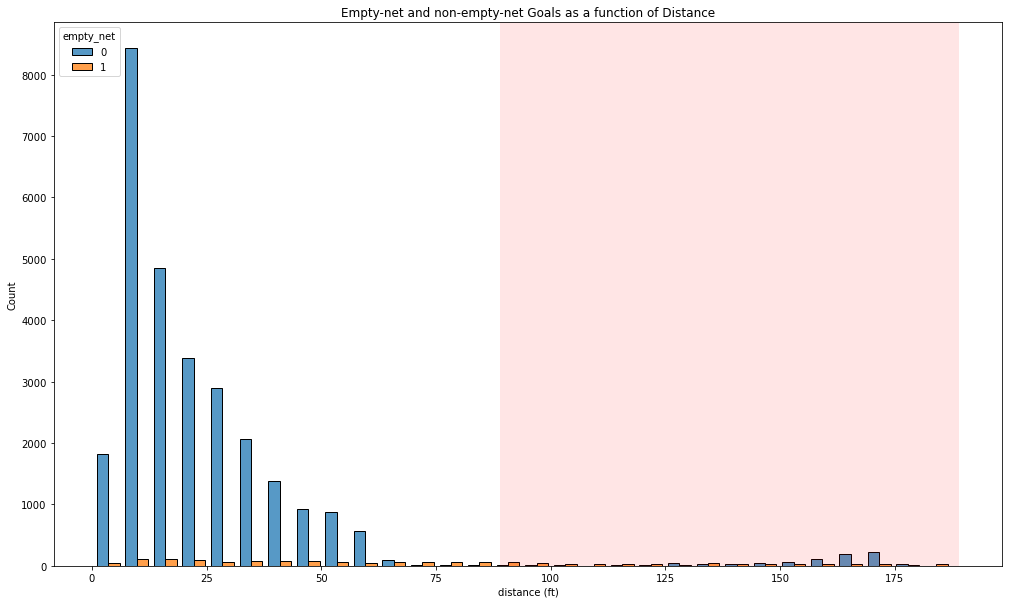

In [24]:
fig, ax = plt.subplots(figsize=(17, 10))
ax = sns.histplot(data=df[(df["is_goal"]==1)], bins=30, x='distance', hue='empty_net',multiple="dodge", shrink=0.8)
ax.set(title='Empty-net and non-empty-net Goals as a function of Distance')
ax.set(xlabel='distance (ft)')
plt.axvspan(89, 189, color='red', alpha=0.1, lw=0)
plt.show()
# Save figure
path = Directory.FIG_DIR + "figure_6_Empty_net_or_not_as_a_function_of_Distance.png"
fig.savefig(path)

In [25]:
len(df[(df['is_goal']==1) & (df['distance']>89) & (df['empty_net']==0)])

795

We put the approximate defense zone in red shade, from 89 feet from the goal up to 180 feet. This is an approximation because distance are measured from the goal and thus are not always calculated perpendicular to the central line. 

# Answer: 
The distribution is coherent with domain-specific knowledge (i.e. that “it is incredibly rare to score a non-empty net goal on the opposing team from within your defensive zone”). Indeed, few successful goals (in total, 795 goals for the complete seasons involved) were shot from more than 89 feet. Based on this, it seems that the features are correct, and we cannot find any events that have incorrect features. 